In [7]:
## Add imports here
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import math
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
# Device and maximum sequence length
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 128

### Low-level Attention Functions ###

def initialise_projections(input_dim, proj_dim):
    Q_proj = nn.Linear(input_dim, proj_dim)
    K_proj = nn.Linear(input_dim, proj_dim)
    V_proj = nn.Linear(input_dim, proj_dim)
    return Q_proj, K_proj, V_proj

def pairwise_similarities(Q, K):
    return torch.matmul(Q, K.transpose(-2, -1))

def attention_scaled(scores, d_k):
    return scores / math.sqrt(d_k)

def attention_softmax(scaled_scores):
    return F.softmax(scaled_scores, dim=-1)

def compute_outputs(attention_scores, V):
    return torch.matmul(attention_scores, V)

def make_causal_mask(seq_len):
    mask = torch.tril(torch.ones(seq_len, seq_len, dtype=torch.bool, device=DEVICE))
    return mask.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, seq_len)

def apply_causal_mask(attention_scores, mask):
    return attention_scores.masked_fill(~mask, float('-inf'))

def split_heads(x, heads):
    batch_size, seq_len, embed_dim = x.size()
    head_dim = embed_dim // heads
    x = x.view(batch_size, seq_len, heads, head_dim)
    return x.permute(0, 2, 1, 3)

def merge_heads(x):
    batch_size, heads, seq_len, head_dim = x.size()
    embed_dim = heads * head_dim
    x = x.permute(0, 2, 1, 3).contiguous()
    return x.view(batch_size, seq_len, embed_dim)

def split_heads_qkv(Q, K, V, heads):
    return split_heads(Q, heads), split_heads(K, heads), split_heads(V, heads)

### Data Loading and Tokenization ###

def load_and_preprocess_data():
    with open("/kaggle/input/scratch-transformers/shakespear_train.txt", "r") as f:
        lines_train = f.readlines()
    with open("/kaggle/input/scratch-transformers/shakespear_dev.txt", "r") as f:
        lines_dev = f.readlines()

    tokens_train = [line.strip().split() for line in lines_train if line.strip()]

    def flat(tokens):
        return [token for sublist in tokens for token in sublist]

    token_counts = Counter(flat(tokens_train))
    specials = ["<PAD>", "<START>", "<STOP>", "<UNK>"]
    vocab = specials + [w for w, _ in sorted(token_counts.items(), key=lambda x: x[1], reverse=True) if w not in specials]
    tokenizer = {word: idx for idx, word in enumerate(vocab)}
    tokenizer_inv = {idx: word for word, idx in tokenizer.items()}

    data_train = [line.strip() for line in lines_train if line.strip()]
    data_val = [line.strip() for line in lines_dev if line.strip()]

    train_dataset = [f"<START> {line} <STOP>" for line in data_train]
    val_dataset = [f"<START> {line} <STOP>" for line in data_val]

    return train_dataset, val_dataset, tokenizer, tokenizer_inv

def pad_to_length(tokens, max_len, tokenizer):
    pad_token = tokenizer["<PAD>"]
    if len(tokens) < max_len:
        tokens = tokens + [pad_token] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len]
    return tokens

def tokenize(sentence, pad_to_len=None, tokenizer=None, include_stop=True):
    if tokenizer is None:
        raise ValueError("Tokenizer must be provided")
    tokens = sentence.split()
    token_ids = [tokenizer.get(token, tokenizer["<UNK>"]) for token in tokens]
    if pad_to_len is not None:
        token_ids = pad_to_length(token_ids, pad_to_len, tokenizer)
    return token_ids

def decode(tokens, tokenizer_inv, end_at_stop=True, omit_pad=True):
    words = []
    for token in tokens:
        word = tokenizer_inv.get(token, "<UNK>")
        if omit_pad and word == "<PAD>":
            continue
        if end_at_stop and word == "<STOP>":
            break
        words.append(word)
    return " ".join(words)

@torch.no_grad()
def evaluate_losses(data, model, tokenizer, bs=32, progress=True, pad_to_len=MAX_LEN):
    it = range(0, len(data), bs)
    if progress:
        it = tqdm(it)
    out = []
    for b_start in it:
        batch = slice(b_start, b_start + bs)
        tokens = torch.tensor(
            [tokenize(t, pad_to_len=pad_to_len, tokenizer=tokenizer) for t in data[batch]], dtype=torch.long
        ).to(DEVICE)
        X_tokens, y_tokens = tokens[:, :-1].contiguous(), tokens[:, 1:].contiguous()
        model.eval()
        logits, _ = model(X_tokens)
        log_probs = F.log_softmax(logits, dim=-1)
        y_log_probs = torch.gather(log_probs, 2, y_tokens[..., None])[..., 0]
        for i in range(y_tokens.shape[0]):
            not_pad = y_tokens[i] != tokenizer["<PAD>"]
            loss = -y_log_probs[i, not_pad].mean()
            out.append(loss.item())
    return out

def generate_text(model, tokenizer, tokenizer_inv, context="<START>", gen_tokens=10, temperature=0.7):
    tokens = tokenize(context, pad_to_len=MAX_LEN, tokenizer=tokenizer)
    tokens = torch.tensor(tokens, dtype=torch.long, device=DEVICE).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        for _ in range(gen_tokens):
            inputs = tokens[:, -MAX_LEN:]
            logits, _ = model(inputs)
            logits_last = logits[:, -1, :] / temperature
            logits_last = torch.nan_to_num(logits_last, nan=-1e9, posinf=-1e9, neginf=-1e9)
            probs = F.softmax(logits_last, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, next_token], dim=1)
            if next_token.item() == tokenizer["<STOP>"]:
                break
    generated_tokens = tokens.squeeze(0).tolist()
    return decode(generated_tokens, tokenizer_inv)

### Transformer Model Definitions (Simplified) ###



TransformerLM(
  (token_embedding): Embedding(12575, 256)
  (position_embedding): Embedding(128, 256)
  (layers): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): MultiHeadAttention(
        (Q_proj): Linear(in_features=256, out_features=256, bias=True)
        (K_proj): Linear(in_features=256, out_features=256, bias=True)
        (V_proj): Linear(in_features=256, out_features=256, bias=True)
        (fc_out): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (fc_out): Linear(in_features=256, out_features=12575, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Epoch 1: Train Loss = 6.3305, Val Loss = 5.8703
Sample text: <START> ANGELO Bec

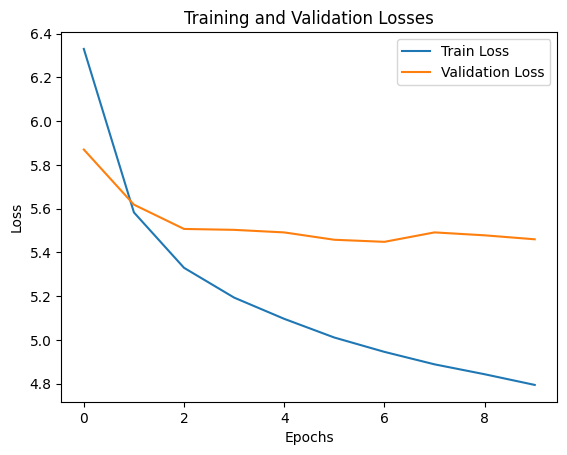

Training perplexity: 171.9300
Validation perplexity: 237.4536


In [8]:
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_layers=2, heads=4, dropout=0.2, max_len=MAX_LEN):
        super(TransformerLM, self).__init__()
        self.embed_dim = embed_dim
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_len, embed_dim)
        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim=embed_dim, heads=heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.max_len = max_len
        self._init_weights()
    
    def _init_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
    
    def forward(self, x):
        batch_size, seq_len = x.size()
        pad_mask = (x != 0).unsqueeze(1).unsqueeze(2)  # [batch_size, 1, 1, seq_len]
        causal_mask = make_causal_mask(seq_len)
        combined_mask = causal_mask & pad_mask
        
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, x, x, combined_mask)
        logits = self.fc_out(x)
        return logits, x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=128, heads=4, expansion_factor=2, dropout=0.2):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_dim, heads)
        self.norm = nn.LayerNorm(embed_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, expansion_factor * embed_dim),
            nn.ReLU(),
            nn.Linear(expansion_factor * embed_dim, embed_dim),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, key, query, value, mask=None):
        attention_out = self.attention(key, query, value, mask)
        attention_out = attention_out + value  # Residual
        attention_norm = self.dropout(self.norm(attention_out))
        fc_out = self.feed_forward(attention_norm)
        fc_out = fc_out + attention_norm  # Residual
        fc_norm = self.dropout(self.norm(fc_out))
        return fc_norm

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=128, heads=4):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        self.head_dim = embed_dim // heads
        self.Q_proj, self.K_proj, self.V_proj = initialise_projections(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, key, query, value, mask=None):
        Q = self.Q_proj(query)
        K = self.K_proj(key)
        V = self.V_proj(value)
        Q, K, V = split_heads_qkv(Q, K, V, self.heads)
        scores = pairwise_similarities(Q, K)
        if mask is not None:
            scores = apply_causal_mask(scores, mask)
        scaled_scores = attention_scaled(scores, self.head_dim)
        attention = attention_softmax(scaled_scores)
        out = compute_outputs(attention, V)
        out = merge_heads(out)
        out = self.fc_out(out)
        return out

### Training and Main Functions ###
def train_model(model, train_dataset, val_dataset, tokenizer, tokenizer_inv, epochs=10, bs=32, lr=0.001):
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(train_dataset), bs):
            batch_text = train_dataset[i:i+bs]
            tokens = [tokenize(t, pad_to_len=MAX_LEN, tokenizer=tokenizer) for t in batch_text]
            tokens = torch.tensor(tokens, dtype=torch.long, device=DEVICE)
            X_tokens, y_tokens = tokens[:, :-1], tokens[:, 1:]
            optimizer.zero_grad()
            logits, _ = model(X_tokens)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y_tokens.reshape(-1), ignore_index=tokenizer["<PAD>"])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / (len(train_dataset) / bs)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i in range(0, len(val_dataset), bs):
                batch_text = val_dataset[i:i+bs]
                tokens = [tokenize(t, pad_to_len=MAX_LEN, tokenizer=tokenizer) for t in batch_text]
                tokens = torch.tensor(tokens, dtype=torch.long, device=DEVICE)
                X_tokens, y_tokens = tokens[:, :-1], tokens[:, 1:]
                logits, _ = model(X_tokens)
                loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y_tokens.reshape(-1), ignore_index=tokenizer["<PAD>"])
                val_loss += loss.item()
        avg_val_loss = val_loss / (len(val_dataset) / bs)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        scheduler.step(avg_val_loss)
        sample_text = generate_text(model, tokenizer, tokenizer_inv, context="<START>", gen_tokens=20)
        print(f"Sample text: {sample_text}")

    # Save the trained model
    torch.save(model.state_dict(), "simplified_transformer_lm.pth")
    print("Model saved as 'simplified_transformer_lm.pth'.")

    # Plot training and validation losses
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Losses")
    plt.show()

    return train_losses, val_losses

# Modify the evaluation function to compute perplexity (ignoring padding tokens)
def calculate_perplexity(model, dataset, tokenizer, tokenizer_inv, bs=32):
    model.eval()
    total_loss = 0
    total_tokens = 0
    with torch.no_grad():
        for i in range(0, len(dataset), bs):
            batch_text = dataset[i:i+bs]
            tokens = [tokenize(t, pad_to_len=MAX_LEN, tokenizer=tokenizer) for t in batch_text]
            tokens = torch.tensor(tokens, dtype=torch.long, device=DEVICE)
            X_tokens, y_tokens = tokens[:, :-1], tokens[:, 1:]
            logits, _ = model(X_tokens)
            log_probs = F.log_softmax(logits, dim=-1)
            y_log_probs = torch.gather(log_probs, 2, y_tokens[..., None])[..., 0]
            
            # Exclude padding tokens from loss calculation
            not_pad = y_tokens != tokenizer["<PAD>"]
            total_loss += -y_log_probs[not_pad].sum().item()
            total_tokens += not_pad.sum().item()

    # Compute perplexity
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    return perplexity

# Function to load model and generate text for testing
def test_model_inference(model_path, test_file, tokenizer, tokenizer_inv, gen_tokens=10):
    model = TransformerLM(vocab_size=len(tokenizer), embed_dim=128, num_layers=2, heads=4, dropout=0.2, max_len=MAX_LEN).to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    with open(test_file, "r") as f:
        test_sentences = f.readlines()
    
    for sentence in test_sentences:
        sentence = sentence.strip()
        generated_text = generate_text(model, tokenizer, tokenizer_inv, context=f"<START> {sentence}", gen_tokens=gen_tokens)
        print(f"Input: {sentence}")
        print(f"Generated: {generated_text}")
        
        # Calculate and print perplexity for the generated text
        perplexity = calculate_perplexity(model, [sentence], tokenizer, tokenizer_inv)
        print(f"Perplexity: {perplexity:.4f}")

# Main function to train and evaluate the model
def main():
    train_dataset, val_dataset, tokenizer, tokenizer_inv = load_and_preprocess_data()
    vocab_size = len(tokenizer)
    model = TransformerLM(vocab_size, embed_dim=32, num_layers=2, heads=4, dropout=0.2, max_len=MAX_LEN).to(DEVICE)
    print(model)
    
    # Train the model and plot the losses
    train_losses, val_losses = train_model(model, train_dataset, val_dataset, tokenizer, tokenizer_inv, epochs=10, bs=128, lr=0.001)
    
    # After training, evaluate the model's perplexity
    print(f"Training perplexity: {calculate_perplexity(model, train_dataset, tokenizer, tokenizer_inv):.4f}")
    print(f"Validation perplexity: {calculate_perplexity(model, val_dataset, tokenizer, tokenizer_inv):.4f}")
    
    # Optionally, save the trained model and use it for inference
    # test_model_inference("simplified_transformer_lm.pth", "test.txt", tokenizer, tokenizer_inv)

if __name__ == "__main__":
    main()